<a href="https://colab.research.google.com/github/vincentyliu2001/BIO74.03-Exercises/blob/main/CompModNervSys_exercise11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BIOL 74.03 (SP23): Computational Modeling of the Nervous System 
# Exercise 11: Simulating Izhikevich neurons and networks

### Exercise goals


1) Learn how to implement simple point neurons with diverse firing properties using the Izhikevich model

2) Characterize different firing patterns exhibited by the Izhikevich model 

2) Simulate network of Izhikevich neurons and quantify responses of populations of neurons


Work through the code below, running each cell, adding code where required, and making sure you understand the output. When you see questions with <font color='red'>***Q:*** </font> preceding them, write your responses in text cells. 


For this exercise, we'll just use `numpy` to implement simple neural network models and visualize their behaviors

In [19]:
import numpy as np
import matplotlib as mpl
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
import matplotlib.pyplot as plt

# Single Izhikevich neurons

The Izhikevich neuron model allows simulation of a diverse range of neuron firing patterns, which correspond to different cell types in the brain. We'll start by writing our own code to numerically solve for the voltage of a single Izhikevich neuron using the forward Euler method. 

The model is a 2D system of ordinary differential equations, given by:

$\frac{dv}{dt} = 0.04v^{2} + 5v + 140 - u + I$

$\frac{du}{dt} = a(bv - u)$, 

with a reset rule for spiking: if $v \geq 30 \; mV$, then set $v$ to $c$ and set $u$ to $u + d$. $v$ represents the membrane potential and $u$ a "recovery" variable that accounts for potassium currents and inactivation of Na currents to produce negative feedback on $v$. Both are unitless parameters, but the values of the constants are set to give values of $v$ in the physiological range in $mV$ (I'll use these hypothetical units in code below). See Izhikevich's [2003 paper](https://www.izhikevich.org/publications/spikes.pdf) for explanation of the other parameters. 

You'll notice, unlike the leaky integrate and fire model, it doesn't have a defined fixed threshold, these equations lead to action potential (AP) firing alone, only requiring the hard reset once the voltage has reached what would be the peak of the AP. 

We'll start by writing a function `simIzhiStep` to simulate the response of single Izhikevich neuron to a step current. Fill in the code below to finish the function.

In [20]:
def simIzhiStep(dt,tstop,v0,u0,params,I_del,I_dur,I_amp,v_reset = 30):
    # Simulate response of single Izhikevich neuron to step current
    # Input arguments:
    #   dt - time step (ms)
    #   tstop - simulation duration (ms)
    #   v0 - initial voltage (mV)
    #   u0 - initial recovery variable (mV/ms)
    #   params - dictionary containing a, b, c, d as key-value pairs
    #   I_del - delay of current step (time of start) (ms)
    #   I_dur - duration of current step (ms)
    #   I_amp - amplitude of current step (mV/ms)
    #   v_reset - reset voltage, peak of AP (mV), default = 30 
    # Outputs: 
    #   t - numpy array of time values 
    #   v - numpy array of voltage values
    #   u - numpy array of u recovery variable values
    #   spike_times - numpy array of spike times 
    a = params['a']
    b = params['b']
    c = params['c']
    d = params['d']
    t = np.arange(0,tstop,dt)
    v = np.zeros(t.shape) # voltage at each time point
    u = np.zeros(t.shape) # u recovery variable at each time point
    I = np.zeros(t.shape) # current at each time point
    I[np.logical_and(t > I_del, t <= I_del + I_dur)] = I_amp # construct vector of current values
    # Initialize v and u
    v[0] = v0
    u[0] = u0
    spike_times = [] # list of spike times
    # Loop over time
    for i in range(0,len(t)-1):
        Ii = I[i] # get current amplitude
        if v[i] >= v_reset:
            v[i+1] = c
            u[i+1] = u[i] + d
            spike_times.append(t[i])
        else:
            # Continue normal integration
            # Compute derivatives
            # Your code goes here
            dv_dt = .04*v[i]**2+5*v[i]+140-u[i]+I[i]
            du_dt = a*(b*v[i] - u[i])
            # Forward euler integration
            v[i+1] = v[i] + dv_dt*dt
            u[i+1] = u[i] + du_dt*dt
    
    spike_times = np.array(spike_times) # convert to numpy array

    return t,v,u,spike_times

Let's use this function to simulate a regular spiking (RS) neuron, characteristic of excitatory cortical pyramidal neurons. We can do this by inputting a `params` dictionary with the following parameter values: `a = 0.02`, `b = 0.2`, `c = -65`, `d = 8`. Define this dictionary and simulate this neuron model with a step current with a delay of $10 \; ms$, duration of $500 \; ms$, and amplitude of $10$, using a time step of $0.01 \; ms$ and duration of $510 \; ms$. Initialize $v$ to -70 and $u$ to $b*v(t=0)$. Then, plot $v$ and $u$ over time on separate axes, using `matplotlib` and `subplot` or a plotting package of your choice. Make sure to label your axes.

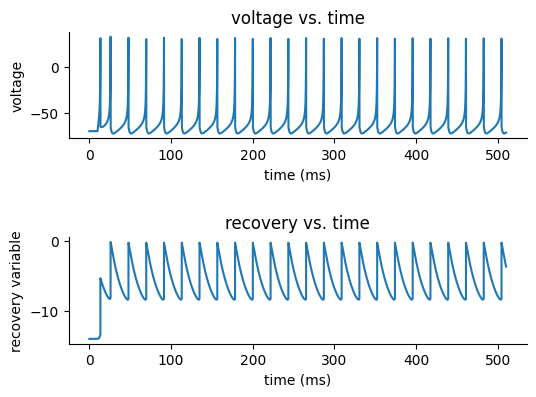

In [21]:
# Your code goes here
# Neuron model settings
params_RS = {
    'a': 0.05,
    'b': 0.2,
    'c': -65,
    'd': 8,
  }
    # write dictionary here with appropriate fields
# Simulation settings
dt = .01
tstop = 510
v0 = -70
u0 = v0*params_RS['b']
I_del = 10
I_dur = 500
I_amp = 10

# Run simulation
t,v,u,spike_times = simIzhiStep(dt,tstop,v0,u0,params_RS,I_del,I_dur,I_amp)

# Plot
fig, ax = plt.subplots(2, 1)
fig.tight_layout(pad=5.0)
ax[0].plot(t, v)
ax[0].set_title('voltage vs. time')
ax[0].set_xlabel('time (ms)')
ax[0].set_ylabel('voltage')
ax[1].plot(t, u)
ax[1].set_title('recovery vs. time')
ax[1].set_xlabel('time (ms)')
ax[1].set_ylabel('recovery variable')
plt.show()

We also kept track of each spike time in the `spike_times` array. We can use this to generate a *raster plot*, which is commonly used visualization of spiking activity. This consists of plotting a point or vertical line at each time point, with the horizontal axis representing time.

Use the `plotRaster` function below to make a raster plot of the spikes from your simulation above. It uses a convenient function in the `matplotlib` library called `eventplot`. 

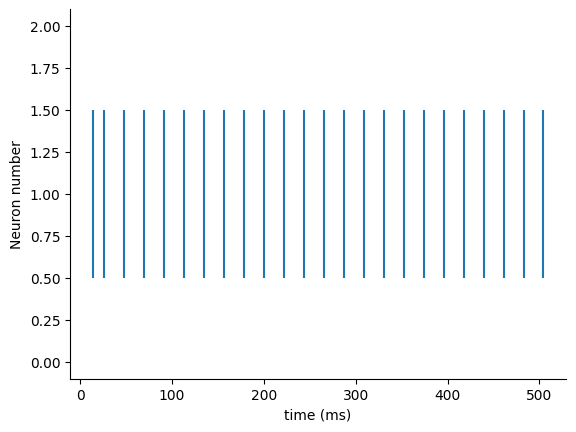

In [22]:
def plotRaster(spike_times,ax=None):
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)
    ax.eventplot(spike_times)
    if isinstance(spike_times,list):
        ax.set_ylim(0,len(spike_times))
    ax.set_xlabel('time (ms)')
    ax.set_ylabel('Neuron number')        

# Call plotRaster here 
plotRaster(spike_times)


As you can see, the firing rate seems to decrease after the first few spikes. In other words, the interval between spikes, or interspike interval (ISI), increases with time. This is known as spike frequency adaptation. One metric to quantify the amount of frequency adapation is the adaptation. The adapation index $A$ is given by:

$ A = \frac{1}{N - k - 1}\sum_{i = k}^{N} \frac{\text{ISI}_i - \text{ISI}_{i-1}}{\text{ISI}_{i} + \text{ISI}_{i-1}} $.

A constant interstimulus interval (no adaptation) gives an adaptation index of 0. If the ISI increases (firing rate slows down) this value increases. 

<font color='red'>**Q1**: The function `calcAdaptationIndex` below implements this function for a vector of spike times. Using this function to calculate the adaptation index, how does varying the $a$ parameter alter the adapatation index? Looking at how this term factors into the model equations, why does it have this effect?
</font>

In [23]:
def calcAdaptationIndex(spike_times):
    isi_vec = spike_times[1:] - spike_times[0:-1]
    N = len(spike_times)
    k = 1 # number of spikes to skip
    A = (1/(N - k - 1)) * np.sum((isi_vec[1:] - isi_vec[0:-1])/(isi_vec[1:] + isi_vec[0:-1]))   
    return A

# Use calcAdapatationIndex and simIzhiStep to answer Q1. 
index = calcAdaptationIndex(spike_times)
print(index)

0.012306143187974917


Increasing the parameter a or decreasing it has the opposite affect on the adaptation index. This makes sense as the spike frequencies increase when the parameter a is increased, resulting in a reduction in the spike adaptation index. We can see that a increases the spike frequency when it is increased because it magnifies the derivative of u, which means that the recovery time is decreased as u increases and decreases more quickly with voltage.

Below, try simulating a fast-spiking neuron, characteristic of inhibitory cortical interneurons. To do this, set `a = 0.1`, `b = 0.2`, `c = -65`, and `d = 2`. Use the same simulation parameters as above and plot the voltage $v$ and recovery variable $u$ vs. time. 

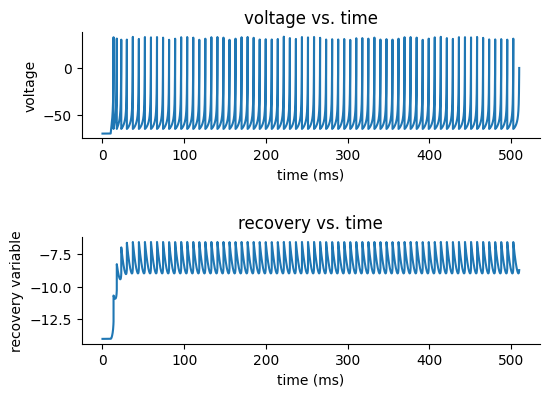

In [24]:
# Your code goes here
params_RS = {
    'a': 0.05,
    'b': 0.2,
    'c': -65,
    'd': 8,
  }
# Neuron model settings
params_FS = {
    'a': 0.1,
    'b': 0.2,
    'c': -65,
    'd': 2,
  }
# Simulation settings
dt = .01
tstop = 510
v0 =-70
u0 = v0*params_FS['b']
I_del = 10
I_dur = 500
I_amp = 10

# Run simulation
t,v,u,spike_times = simIzhiStep(dt,tstop,v0,u0,params_FS,I_del,I_dur,I_amp)


# Plot
fig, ax = plt.subplots(2, 1)
fig.tight_layout(pad=5.0)
ax[0].plot(t, v)
ax[0].set_title('voltage vs. time')
ax[0].set_xlabel('time (ms)')
ax[0].set_ylabel('voltage')
ax[1].plot(t, u)
ax[1].set_title('recovery vs. time')
ax[1].set_xlabel('time (ms)')
ax[1].set_ylabel('recovery variable')
plt.show()

<font color='red'>**Q2**: What change in the parameters explain the change in firing behavior of the FS vs. RS neuron and why?
</font>

The two numbers that we changed are a and d. As explained before, a increases the spike frequency of the neuron due to its effect on the derivative of u with respect to time. When changing d, we decrease what the recovery variable is set to after the cell reaches the v_reset threshold. When this is decreased, it reduces the negative affect on voltage due to potassium currents and inactivation of Na which allows the cell to build up more voltage more quickly, and thus increasing the spike frequency.

# Izhikevich network

To simulate a network of synaptically connected Izhikevich neurons, we'll turn to the simple "pulse-coupled" implementation from the same Izhikevich 2003 paper. Rather than using conductance based synapses we've developed previously, synaptic activation causes an instantaneous increase in current injection. This network is made up of 80% excitatory and 20% inhibitory neurons, matching the proportion found in the brain. For the excitatory neurons, he used the regular spiking firing type, and for the inhibitory neurons, he used the fast spiking type, which we simulated above. However, neurons of the same cell type and firing type actually exhibit significant heterogenity in real life; to introduce this in the model, Izhikevich added random variability to $d$ (the after-spike reset parameter for $u$) for the excitatory neurons, and he added random variability to the recovery time scale variable $a$ and sensitivity variable $b$ for the inhibitory neurons. We'll follow the MATLAB implementation shown in that paper, with some modifications to make our code more general. 

Below, we define a function to construct the network called `makeIzhiNet`. This generates the parameter values and a connectivity or *weight* matrix for the network `S`. Since we haven't seen these before, let's take a moment to understand how this works. Try using this function to make a network with 8 excitatory (`Ne`), 2 inhibitory neurons (`Ni`), mean excitatory weight `mean_we = 0.5` and mean inhibitory weight `mean_wi = 1` (although these latter two won't matter for now). 

Then, visualize the weight matrix `S` using the provided plotting code.

(<Figure size 800x800 with 2 Axes>,
 <Axes: xlabel='Presynaptic neuron number', ylabel='Postsynaptic neuron number'>)

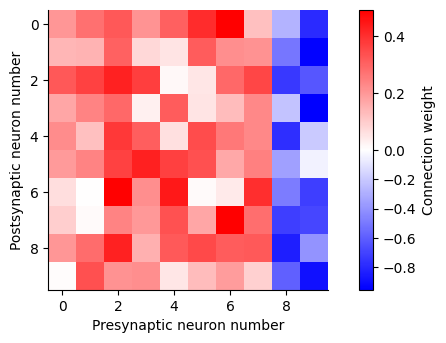

In [25]:
import matplotlib.colors as mcolors

def makeIzhiNet(Ne,Ni,mean_we,mean_wi,rng=None):
    # Construct Izhikevich network of RS/FS excitatory/inhibitory neurons
    # Input arguments:
    #   Ne - Number of excitatory neurons
    #   Ni - Number of inhibitory neurons
    #   mean_we - mean weight of excitatory synapses
    #   mean_wi - mean weight of inhibitory synapses (negative sign included below)
    #   rng - random number generator, if empty generates new generator
    if rng is None:
        rng = np.random.default_rng()

    re = rng.uniform(0,1,size = Ne) # random values drawn from uniform distribution for excitatory neurons
    ri = rng.uniform(0,1,size = Ni) # random values drawn from uniform distribution for inhibitory neurons
    # Arrays of parameter values (allow variabillity between neurons in network)
    a = np.concatenate((0.02*np.ones(Ne),0.02 + 0.08*ri), axis = 0)
    b = np.concatenate((0.2*np.ones(Ne),0.25 - 0.05*ri), axis = 0)
    c = np.concatenate((-65 + 15*re**2,-65*np.ones(Ni)), axis = 0)
    d = np.concatenate((8 - 6*re**2,2*np.ones(Ni)), axis = 0)
    # Define connectivity matrix
    S = np.concatenate((np.abs(mean_we)*rng.uniform(size=(Ne+Ni,Ne)),
                        -1*np.abs(mean_wi)*rng.uniform(size=(Ne+Ni,Ni))),axis = 1)
    return S, a, b, c, d


def plotNetwork(S):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(211)
    norm = mcolors.TwoSlopeNorm(vmin=S.min(), vmax = S.max(), vcenter=0)
    I = ax.imshow(S,cmap='bwr',norm=norm)
    ax.set_xlabel('Presynaptic neuron number')
    ax.set_ylabel('Postsynaptic neuron number')
    cbar = plt.colorbar(I,);
    cbar.set_label('Connection weight')
    return fig, ax


# Your code goes here
# Call makeIzhiNet and return S, then input to plotNetwork
S, a, b, c, d = makeIzhiNet(8, 2, 0.5, 1)
plotNetwork(S)



Since we have 10 neurons, the connectivity matrix is a $10 \times 10$ matrix. Each row/column represents a neuron, with the columns representing the index of the presynaptic neuron and rows representing the index of postsynaptic neuron. So the first row has the weights of connections made from all neurons onto the first neuron. The diagonal shows the weight of self connections. For example, row 3, column 4 holds the strength of the synaptic connection from neuron 4 onto neuron 3 (don't forget python is zero indexed, so the 4th and 5th neuron respectively). We've constructed the weight matrix so that the first `Ne` rows are the weights of synapses from the excitatory neurons to all other neurons, and the remaining rows are the inhibitory neurons (neuron 9 and 10 in this case). 

Okay, now let's combine these parameter arrays and the weight matrix with a function to simulate the network's activity, given by `simIzhiNet` below. Again, we'll use the forward Euler method. 

In [26]:
from numpy import matlib

def simIzhiNet(a,b,c,d,S,v0,dt,tstop,I0,rng=None,v_th=30):
    # Simulate Izhikevich network
    # Input arguments:
    #   a - vector of a values for N neurons in network
    #   b - vector of b values for N neurons in network
    #   c - vector of a values for N neurons in network
    #   d - vector of d values for N neurons in network
    #   S - connectivity/weight matrix (N x N)
    #   v0 - initial voltage (either scalar or N length array)
    #   dt - time step (ms)
    #   tstop - simulation duration (ms)
    #   I0 - scaling factor for random current injection (normal distribution) in each neuron
    #   rng - random number generator, if empty generates one internally
    #   v_th - threshold for AP (default = 30 mV)
    # Outputs:
    # t - time vector
    # v - matrix of voltage recordings in each neuron (Nt x N) 
    # u - matrix of recovery variable in each neuron (Nt x N)
    # spike_times - list of N spike time arrays for each neuron, each spike time array is of variable length depending
    #               on number of spikes that occurred in that neuron

    if rng is None:
        rng = np.random.default_rng()
    N = len(a) # number of neurons
    t = np.arange(0,tstop,dt) # time vector
    Nt = len(t) # number of time points
    v = np.zeros((t.shape[0],N)) # voltage at each time point for each neuron (rows are time points, columns are neurons)
    u = np.zeros((t.shape[0],N)) # u recovery variable at each time point for each neuron (rows are time points, columns are neurons)
    v[0,:] = v0
    u[0,:] = b*v0
    spike_times = [[] for _ in range(N)] # set of empty lists for spike times in each neuron

    print(f'Simulating network of {N} neurons for {tstop} ms')
        
    for i in range(0,Nt-1):                
        I = I0*rng.normal(loc=0,scale=1,size=N)                        
        # Check if any cells fired    
        fired = v[i,:] >= v_th
        # Save spike timings
        if np.any(fired):
            for fi in np.argwhere(fired)[0]:
                spike_times[fi].append(t[i]) # store spike time for this neuron
            # Reset values    
            v[i,fired] = v_th # clip at AP peak        
            v[i+1,fired] = c[fired]            
            u[i+1,fired] = u[i,fired] + d[fired]
            I = I + np.sum(S[:,fired],axis=1) # add current from sum of presynaptic neurons that fired an AP for each neuron    
        # Integrate next time step if didn't fire
        # Compute derivatives
        nf = np.logical_not(fired) # neurons that didn't fire
        dv_dt = 0.04*v[i,:]**2 + 5*v[i,:] + 140 - u[i,:] + I
        du_dt = a*(b*v[i,:] - u[i,:])        
        v[i+1,nf] = v[i,nf] + dv_dt[nf]*dt
        u[i+1,nf] = u[i,nf] + du_dt[nf]*dt
        
    return t,v,u,spike_times


Now, finish the code block below to use this function to simulate a network of 800 excitatory and 200 inhibitory neurons, with mean excitatory synaptic weight of 1 and inhibitory weight of 3. Set the time step to 0.1 ms and simulate 500 ms of activity. Use mean current stimuli amplitudes of 25 and 15 for the excitatory and inhibitory neurons, which represents extrinsic inputs (like from the thalamus) with randomly fluctuation synaptic inputs. Use a time step of 0.1 ms and duration of 1 second. Then, make a raster plot and plot the voltage over time for a few example neurons of your choosing.

Simulating network of 1000 neurons for 1000 ms


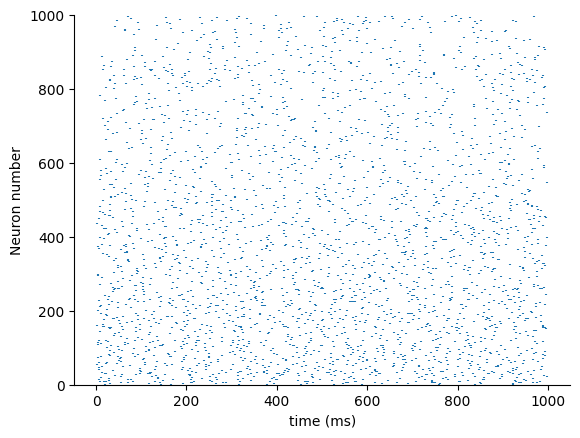

In [27]:
# Network parameters
Ne = 800
Ni = 200
mean_we = 0.5 # 0.5
mean_wi = 1 # 1
rng = np.random.default_rng(seed=123)
# Simulation parameters
dt = .1
tstop = 1000
I0 = np.concatenate((25*np.ones(Ne),15*np.ones(Ni)),axis=0)
v0 = -65

S, a, b, c, d = makeIzhiNet(Ne,Ni,mean_we,mean_wi,rng) # Make network

t,v,u,spike_times = simIzhiNet(a,b,c,d,S=S,v0=v0,dt=dt,tstop=tstop,I0=I0,rng=rng) # Simulate network

# Plot here
plotRaster(spike_times)

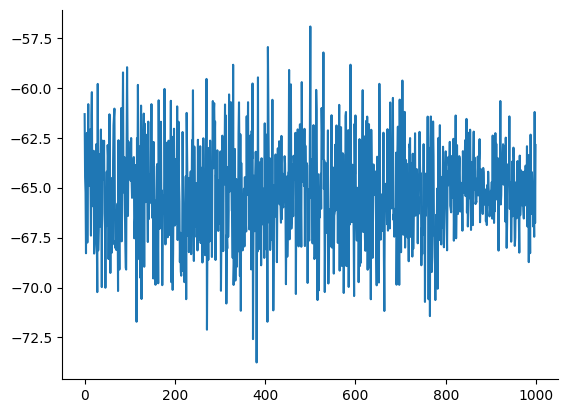

In [35]:
plt.plot(t[::10], v[1])

We've quantified firing rates previously by counting the number spikes and dividing by the duration. This is technically the *mean* firing rate and works fine for a neuron firing at regular intervals, but if its firing interval changes, either due to intrinsic properties or changes in extrinsic inputs, we need to quantify how the firing rate changes over time. Firing rates are thought to be one of the primary ways neurons encode information. To quantify firing rate over time, we typically divide time into sampling windows or *bins* $\Delta t$ and calculate the firing rate in that window by dividing the number of spikes that occurred by $\Delta t$. Plotting this quantity $f(t)$ over time after a stimulus or event i sknown as the *poststimulus time histogram* (PSTH). Across a population, we can compute the mean firing rate within each bin by dividing by the number of neurons. Use `calcFiringRate` to plot the mean firing rate over time for the network simulation you ran above. Use a bin size of $50 \; ms$. 

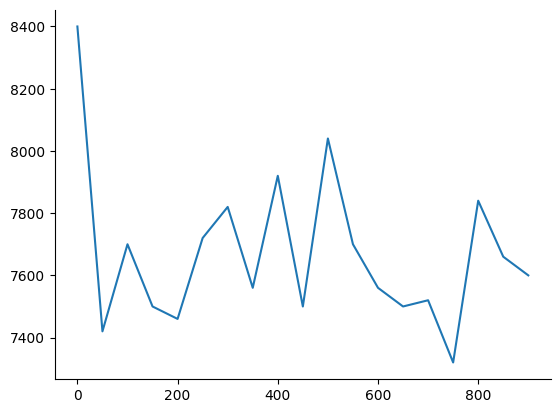

In [38]:
def calcFiringRate(t,spike_times,bin_size):
    t_bins = np.arange(0,t[-1],bin_size)  
    if isinstance(spike_times,list):
        N = np.zeros(len(t_bins)-1)
        for s in spike_times:
            Ns,_ = np.histogram(s,t_bins) # get number of spike at each time point using histogram        
            N += Ns
    else:
        N,_ = np.histogram(spike_times,t_bins) # get number of spike at each time point using histogram
    firing_rate = N/(bin_size*1e-3)    
    t_bins = t_bins[:-1]
    return t_bins, firing_rate # time and firing rate

bin_size = 50 # ms - bin size

# Plot here
t_bins, firing_rate = calcFiringRate(t, spike_times, bin_size)
plt.plot(t_bins, firing_rate)


But calculating firing rate in this way makes the rate sensitive to the exact location of the bins. With more variable firing times, particularly with real neurons, this becomes even more of a problem. Instead, we can estimate firing rate over time by sliding a window across our recording and summing the spikes in that window. Mathematically, this is known as a [*convolution*](https://en.wikipedia.org/wiki/Convolution). If we weight all points within the window equally, you can think of that sliding window as rectangular, but you can also weight points within the window differently, for example, using a Gaussian function. The shape of this window is known as the *kernel*. Using a sliding rectangle is also known as a moving average.

Below, `calcFiringRateSmooth` allows you to use either a moving average or gaussian kernel to calculate the firing rate over time. Plot the mean population firing rate over time using the three methods we've now implemented, the fixed PSTH above, and the sliding rectangular or gaussian window. Use a kernel window of $20 \; ms$.

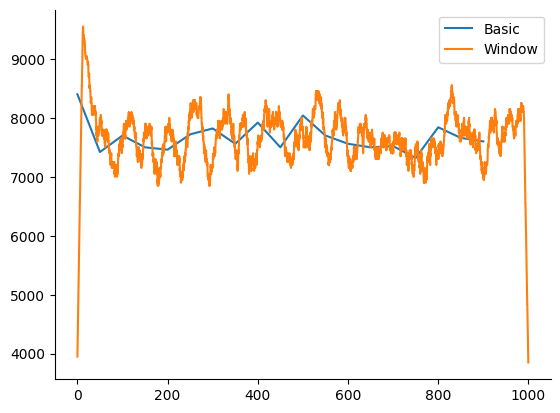

In [45]:

def gaussian(dt,sigma):
    # zero centered gaussian
    width_dt = int(np.round(2*sigma/dt)) # width of window (4*sigma + dt)
    x = np.arange(-width_dt,width_dt+1)
    G = np.exp(-x**2/(2*(sigma/dt)**2)) # *(1/(sigma*np.sqrt(2*np.pi)))    
    # normalize to sum to 1
    G = G/np.sum(G)
    return G

def calcFiringRateSmooth(t,spike_times,method=1,kernel_size=10):
    # Calculate firing rate with smoothing window
    # t - time vector (ms)
    # spike_times - vector of spike times in ms
    # method - 1 or 2
    #   1 - moving average/rectangular kernel
    #   2 - gaussian kernel
    # kernel_size - size of kernel in ms, for moving average (method = 1), this is width of moving average
    #   for gaussian (method = 2), this is width of gaussian. Number of points used is 4*kernel_size+1
    
    dt = t[1] - t[0]
    t_bins = np.arange(dt/2,t[-1]+dt/2,dt) # center bins on simulation time points
    if isinstance(spike_times,list):
        N = np.zeros(len(t_bins)-1)
        for s in spike_times:
            Ns,_ = np.histogram(s,t_bins) # get number of spike at each time point using histogram
            N += Ns
    else:    
        N,_ = np.histogram(spike_times,t_bins) # get number of spike at each time point using histogram
    t_bins = t_bins[:-1]
    
    kernel_samples = int(kernel_size/dt) # number of time points in kernel
    if method == 1: # moving average, rectangular kernel        
        kernel = np.ones(kernel_samples)/(kernel_size*1e-3) # kernel normalized to give units of Hz
    elif method == 2: # gaussian kernel    
        kernel = gaussian(dt,kernel_size)/(dt*1e-3) # kernel normalized to give units of Hz
    
    firing_rate = np.convolve(N,kernel,mode='same')    
    return t_bins, firing_rate

# Plot output of calcFiringRate and calcFiringRateSmooth 
t_bins, firing_rate = calcFiringRate(t, spike_times, bin_size)
plt.plot(t_bins, firing_rate, label="Basic")
t_bins, firing_rate = calcFiringRateSmooth(t, spike_times, kernel_size=20)
plt.plot(t_bins, firing_rate, label="Window")
plt.legend()